In [1]:
import os
import jax
import sys
import numpy as np
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

In [2]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [3]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [6]:
jax.device_count()

1

In [3]:
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

In [22]:
import os

img_dir = "../images/"

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "PMC4582529_JoU-2012-0014-g020.jpg"
caption = " Plain X-ray of the abdomen showing a well-defined, rounded soft tissue density mass, in the central abdominal region with calcification (arrows)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)

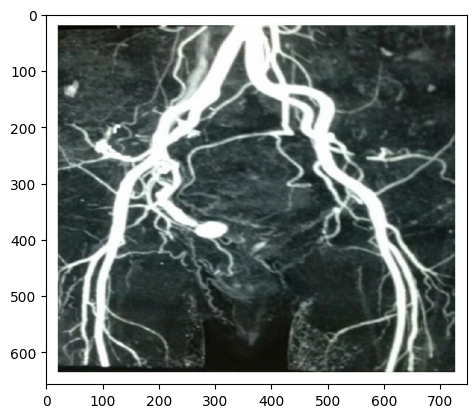

In [23]:
# Let's load a sample image
import os
img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')

In [24]:
class Transform(torch.nn.Module):
    def __init__(self, image_size=224):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size, image_size], interpolation=InterpolationMode.BICUBIC),
            ConvertImageDtype(torch.float),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
        return x

In [25]:
sentences = [f'{c} with' for c in classes]
print(sentences)

['man with', 'woman with']


In [26]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform()
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
outputs = model(**inputs)

/home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [27]:
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)

In [28]:
outputs = model(**inputs)

In [29]:
outputs.logits_per_image.shape
outputs

FlaxCLIPOutput(logits_per_image=Array([[nan, nan]], dtype=float32), logits_per_text=Array([[nan],
       [nan]], dtype=float32), text_embeds=Array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32), image_embeds=Array([[-0.0735503 ,  0.01616245,  0.06667878, -0.03978654, -0.03054803,
         0.05371238,  0.0559126 ,  0.02405456,  0.0265683 ,  0.055201  ,
         0.00547896,  0.07593693,  0.00575397, -0.00758916,  0.06757729,
        -0.01982128, -0.03283108,  0.01069248, -0.04004146, -0.02195383,
         0.04615482, -0.01043448,  0.02840632,  0.03638302, -0.06303416,
         0.00921539,  0.03141659, -0.02720306, -0.02717586, -0.008165  ,
        -0.00352337, -0.04380215, -0.05205552, -0.04523959,  0.03851348,
        -0.00220547,  0.02232138,  0.03041826, -0.01210764, -0.04017227,
         0.01777606, -0.03923308, -0.02035925,  0.04063467, -0.00724724,
         0.1059614 ,  0.04616366,  0.00293882, -0.03828006, -0.07665942,
        -0.

In [30]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

man with: nan
woman with: nan


In [31]:
query = 'carcinoma'
img_list = os.listdir(img_dir)[:10]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
outputs = model(**inputs)
print(outputs)

FlaxCLIPOutput(logits_per_image=Array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32), logits_per_text=Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32), text_embeds=Array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, na

In [32]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

PMC4844886_CRIU2016-5895016.001.jpg: nan
PMC2998047_fnsys-04-00145-g002.jpg: nan
PMC3640236_NMJ-53-184-g001.jpg: nan
PMC4303756_ogs-58-69-g001.jpg: nan
PMC4722559_JOCR-4-15-g001.jpg: nan
PMC4881676_ACA-18-587-g002.jpg: nan
PMC3366477_jcav03p0226g06.jpg: nan
PMC3621857_ebsj02035-4.jpg: nan
PMC4501134_IJO-63-394-g003.jpg: nan
PMC3931632_ott-7-289Fig1.jpg: nan


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])